# Fine vs coarse annotation - lung analysis

In this notebook we compare targets prioritized using coarse CellxGene annotations and fine uniform annotations on lung diseases, using labels from the Human Lung Cell Atlas ([Sikkema et al. 2023](https://www.nature.com/articles/s41591-023-02327-2))

In [5]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
# import cellxgene_census

In [6]:
import upsetplot

In [7]:
from sc_target_evidence_utils import preprocessing_utils
from sc_target_evidence_utils import DE_utils, cellontology_utils

In [8]:
import json

In [9]:
from sc_target_evidence_utils import cellontology_utils
output_dir = '../data/'
graph = cellontology_utils.get_cellontology_graph(output_dir)

R plotting setup

In [10]:
## r2py setup
# import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# anndata2ri.activate()

In [11]:
%load_ext rpy2.ipython

In [12]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [13]:
figdir = '/home/jovyan/mount/gdrive/sc_targetID/plots/association_results/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [14]:
%%R -i figdir

# utils
ggsave_figdir <- function(output_name, width, height){
    ggsave(paste0(figdir, output_name, '.png'), width = width, height = height) 
    ggsave(paste0(figdir, output_name, '.pdf'), width = width, height = height)
}


In [15]:
%%R

### Plotting utils
evidence_labels <- c(
    "all_sc_evidence" = "cell type & disease marker", 
    "bulk_disease_evidence" = "DE in disease (tissue)", 
    "disease_ct_evidence" = "DE in disease (cell type)", 
    "disease_evidence" = "Disease cell specific", 
    "ct_marker_evidence" = "Cell type specific", 
    "has_genetic_support" = "GWAS association"
    )

universe_labels <- c(
    'protein_coding_targets'= 'protein-coding targets',
    'sm_tractable_targets' = 'SM tractable targets',
    'ab_tractable_targets' = "Ab tractable targets",
    'known_drug_targets' = 'known drug targets\n(reached phase I)',
    'nuclear_receptors' = 'nuclear receptors', 
    'catalytic_receptors' = 'catalytic receptors', 
    'rhodop_gpcr' = 'rhodopsin-like\nGPCRs', 
    'transporters' = 'transporters', 
    'kinases' = 'kinases', 
    'enzymes' = 'enzymes', 
    'ion_channels' = 'ion channels'
    )


# Plot odds-ratio (no faceting)
plot_OR <- function(
    results_all_df, 
    pval_alpha=0.05, 
    base_font_size=20,
    text_position='right',
    y_value = 'clinical_status',
    evidence_levels = c('ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence', 'has_genetic_support', 'all_sc_evidence', 'is_hvg_normal', 'is_hvg_disease'),
    clinical_status_levels = c(rev(c('druggable', 'safe', 'effective', 'approved')))
){
    pl_df <- results_all_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=clinical_status_levels)) %>%
        mutate(evidence = factor(evidence, levels=evidence_levels)) %>%
        mutate(is_signif = pval < pval_alpha) %>%
        rename(setNames(y_value,'y_val'))
    
    # Don't show values with no support
    max_OR <- max((pl_df[,'ci_high']))
    
    pl <- ggplot(pl_df, aes(y=y_val, x=odds_ratio, color=is_signif)) +
        geom_point(
            data = . %>% filter(n_supported_approved > 0),
            size=3
        ) +
        geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                        aes(xmin=ci_low, xmax=ci_high)) +
        geom_text(aes(label = paste0(n_supported_approved,' / ', n_success)), 
                  x = ifelse(text_position == 'right', Inf, -Inf) , 
                  hjust= ifelse(text_position == 'right', 1.1, -1) , 
                  size=5,
                  color='black',) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10() +
        xlab('Odds Ratio') +
        ylab('Drug target class') +
        theme_classic(base_size=base_font_size) +
        scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                           name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
        theme(strip.text.y=element_text(angle=0), strip.background = element_rect(color=NA, fill = "grey"))    
    pl
}

In [16]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'

## Small molecule / antibody tractable targets
nelson_anno_dataset = data_dir + 'genetic_support/data/gene_lists/' ## Downloaded from https://github.com/ericminikel/genetic_support
gene_annotations = [x for x in os.listdir(nelson_anno_dataset) if x.endswith(".tsv")]

annos = {}
for g in gene_annotations:
    anno_name = g.split(".tsv")[0]
    annos[anno_name] = pd.read_table(nelson_anno_dataset + g, header=None).values.flatten()

ens_ids_to_name = genes[['gene_id', 'gene_name']].copy()
annos.pop('ab_tractable')
annos.pop('sm_tractable')

array(['TARBP1', 'SMG6', 'P2RX5', ..., 'GPR25', 'C3AR1', 'PPIA'],
      dtype=object)

In [17]:
reversed_annos = {value: key for key, values in annos.items() for value in values}

In [18]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'

## Small molecule / antibody tractable targets
nelson_anno_dataset = data_dir + 'genetic_support/data/gene_lists/' ## Downloaded from https://github.com/ericminikel/genetic_support
gene_annotations = [x for x in os.listdir(nelson_anno_dataset) if x.endswith(".tsv")]

annos = {}
for g in gene_annotations:
    anno_name = g.split(".tsv")[0]
    annos[anno_name] = pd.read_table(nelson_anno_dataset + g, header=None).values.flatten()

ens_ids_to_name = genes[['gene_id', 'gene_name']].copy()
annos.pop('ab_tractable')
annos.pop('sm_tractable')

array(['TARBP1', 'SMG6', 'P2RX5', ..., 'GPR25', 'C3AR1', 'PPIA'],
      dtype=object)

## Load metadata

In [3]:
## Load donor metadata in cxg
cxg_metadata = pd.read_csv('../data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

In [4]:
disease_info_df = cxg_metadata[['disease_relevant_tissue', 'disease_ontology_id', 'disease']].drop_duplicates()
disease_name_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease']))
disease_tissue_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease_relevant_tissue']))

In [9]:
lung_cxg_metadata = cxg_metadata[cxg_metadata['tissue_general'] == 'lung'].copy()

Save IDs for lung disease of interest: selecting COPD, pulmonary fibrosis, pneumonia and cystic fibrosis which have samples only from HLCA (fine celltype annotation available)

In [10]:
lung_disease_ids = [x for x in lung_cxg_metadata.disease_ontology_id.unique() if x.startswith('MONDO')]

In [11]:
select_diseases = ['pulmonary fibrosis', 'cystic fibrosis', 'chronic obstructive pulmonary disease','pneumonia']
select_diseases_ids = [k for k,v in disease_name_mapper.items() if v in select_diseases]
select_diseases_ids

['MONDO:0002771', 'MONDO:0005249', 'MONDO:0009061', 'MONDO:0005002']

In [12]:
lung_cxg_metadata[lung_cxg_metadata.disease.isin(select_diseases)].groupby(['disease', 'dataset_id']).size()

disease                                dataset_id                          
chronic obstructive pulmonary disease  1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1    18
cystic fibrosis                        9f222629-9e39-47d0-b83f-e08d610c7479    22
pneumonia                              9f222629-9e39-47d0-b83f-e08d610c7479    13
pulmonary fibrosis                     9f222629-9e39-47d0-b83f-e08d610c7479     6
dtype: int64

## Download extended HLCA data with annotations

In [13]:
output_dir = '../data/'

In [14]:
OBS_COLS = [
            "assay", 
            "tissue_general", 
            "suspension_type", 
            "disease", 
            'donor_id', 
            'cell_type_ontology_term_id',
            'cell_type',
            'is_primary_data'
    ]

# Subset to relevant datasets
dataset_ids = ['9f222629-9e39-47d0-b83f-e08d610c7479']
tissue_ids = ['lung']

Download from cellxgene census (`dataset_id = 9f222629-9e39-47d0-b83f-e08d610c7479`)

In [15]:
# cellxgene_census.download_source_h5ad('9f222629-9e39-47d0-b83f-e08d610c7479', to_path='../data/hlca_census.h5ad', census_version = "2023-07-25")

In [194]:
hlca_adata_full = sc.read_h5ad('../data/hlca_census.h5ad', backed=True)

In [34]:
del hlca_adata_full.layers['soupX']
del hlca_adata_full.obsp
del hlca_adata_full.obsm

In [35]:
import gc
gc.collect()

4352

In [37]:
## Load target data
targets = pd.read_csv('../data/TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.csv', index_col=0)

In [38]:
# disease_ontology_id = select_diseases_ids[0]

In [39]:
select_diseases_ids

['MONDO:0002771', 'MONDO:0005249', 'MONDO:0009061', 'MONDO:0005002']

In [ ]:
output_dir = '../data/'
# for disease_ontology_id in select_diseases_ids[1:]:
disease_ontology_id = 'MONDO:0005002'
## Get list of all possible genes you might need 
if "_" in disease_ontology_id:
    disease_ontology_id = disease_ontology_id.replace("_", ":")
target_genes = targets[targets['cxg_matched_id'] == disease_ontology_id.replace(":", "_")].targetId.tolist()

json_file =   output_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

all_genes_ls = sum([x for x in universe_dict.values()], [])
all_genes_ls.extend(target_genes)
all_genes_ls = list(set(all_genes_ls))

## Filter full dataset
disease_ids = ['PATO:0000461', disease_ontology_id]
hlca_adata = hlca_adata_full[(hlca_adata_full.obs['tissue'].isin(['lung', 'lung parenchyma'])) & 
                        (hlca_adata_full.obs['disease_ontology_term_id'].isin(disease_ids)) &
                        (hlca_adata_full.obs['is_primary_data'])
                       ]

hlca_adata_X = hlca_adata.raw.to_adata()
raw_sum = np.array(hlca_adata_X.X.sum(1)).flatten()

hlca_adata_X = hlca_adata_X[:, hlca_adata_X.var_names.isin(all_genes_ls)].copy()
hlca_adata_X.obs['tissue_general'] = 'lung'
hlca_adata_X.obs = hlca_adata_X.obs[OBS_COLS].copy()
hlca_adata_X.obs['total_counts'] = raw_sum
hlca_adata_X.obs['disease_ontology_id'] = disease_ontology_id

# Exclude blacklisted assays
assay_blacklist = [
    'BD Rhapsody Targeted mRNA',
    'STRT-seq',
    'inDrop'
    ]

hlca_adata_X = hlca_adata_X[~hlca_adata_X.obs['assay'].isin(assay_blacklist)].copy()

# Store fine annotation
hlca_adata_X.obs['cell_type'] = hlca_adata.obs['ann_finest_level'].copy()
hlca_adata_X.obs["high_level_cell_type_ontology_term_id"] = [
    x if x != 'Unknown' else 'low_quality_annotation' for x in hlca_adata_X.obs['cell_type']
    ]

# Pseudo-bulk by celltype-donor
print("Pseudo-bulking...")
pbulk_adata = preprocessing_utils.anndata2pseudobulk(hlca_adata_X, 
                                 group_by=['high_level_cell_type_ontology_term_id', 'assay', 'suspension_type', 'disease', 'donor_id'],
                                 min_ncells=5       
                                )

pbulk_adata = pbulk_adata[pbulk_adata.obs['high_level_cell_type_ontology_term_id'] != 'low_quality_annotation'].copy()
pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].copy()

pbulk_adata.obs['sample_id'] = ['-'.join(x[1:]) for x in pbulk_adata.obs_names.str.split("-")]
pbulk_adata.obs['disease_ontology_id'] = disease_ontology_id

# Save
pbulk_adata.write_h5ad(output_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":","_")}.pbulk_all_genes.h5ad')

### Visualize fine vs coarse annotation

In [201]:
fine_anno_obs = 'ann_finest_level'
coarse_anno_obs = 'cell_type'

# Clean cell ontology
ct_counts = hlca_adata_full.obs["cell_type_ontology_term_id"].value_counts()
ontology_terms = ct_counts[ct_counts > 5].index.tolist()
ct_rename_dict = cellontology_utils.rename_cts_to_high_level(ontology_terms, graph)
hlca_adata_full.obs["high_level_cell_type_ontology_term_id"] = [
    ct_rename_dict[x] if x in ct_rename_dict.keys() else 'low_quality_annotation' for x in hlca_adata_full.obs["cell_type_ontology_term_id"] 
    ]


In [209]:
from networkx import MultiDiGraph
from scanpy.metrics import confusion_matrix

# Make confusion table
confmat = confusion_matrix(
    fine_anno_obs, "high_level_cell_type_ontology_term_id", data=hlca_adata_full.obs, normalize=False
)
confmat_nonzero = confmat.replace(0, np.nan)

# Sort by number of grouped annotations
df = hlca_adata_full.obs[[fine_anno_obs, "high_level_cell_type_ontology_term_id"]].drop_duplicates()
df.columns = ["original", "new"]
df = pd.merge(df, df.value_counts("new").reset_index())
df.columns = ['original', 'new', 'count']
df = df.sort_values(["count", "new"], ascending=False)
confmat_nonzero = confmat_nonzero.loc[df["original"], df["new"].unique()]

In [211]:
# Rename
confmat_nonzero.columns = [
    f"{ontology2name(x, graph)} ({x})" if x != "low_quality_annotation" else x for x in confmat_nonzero.columns
]

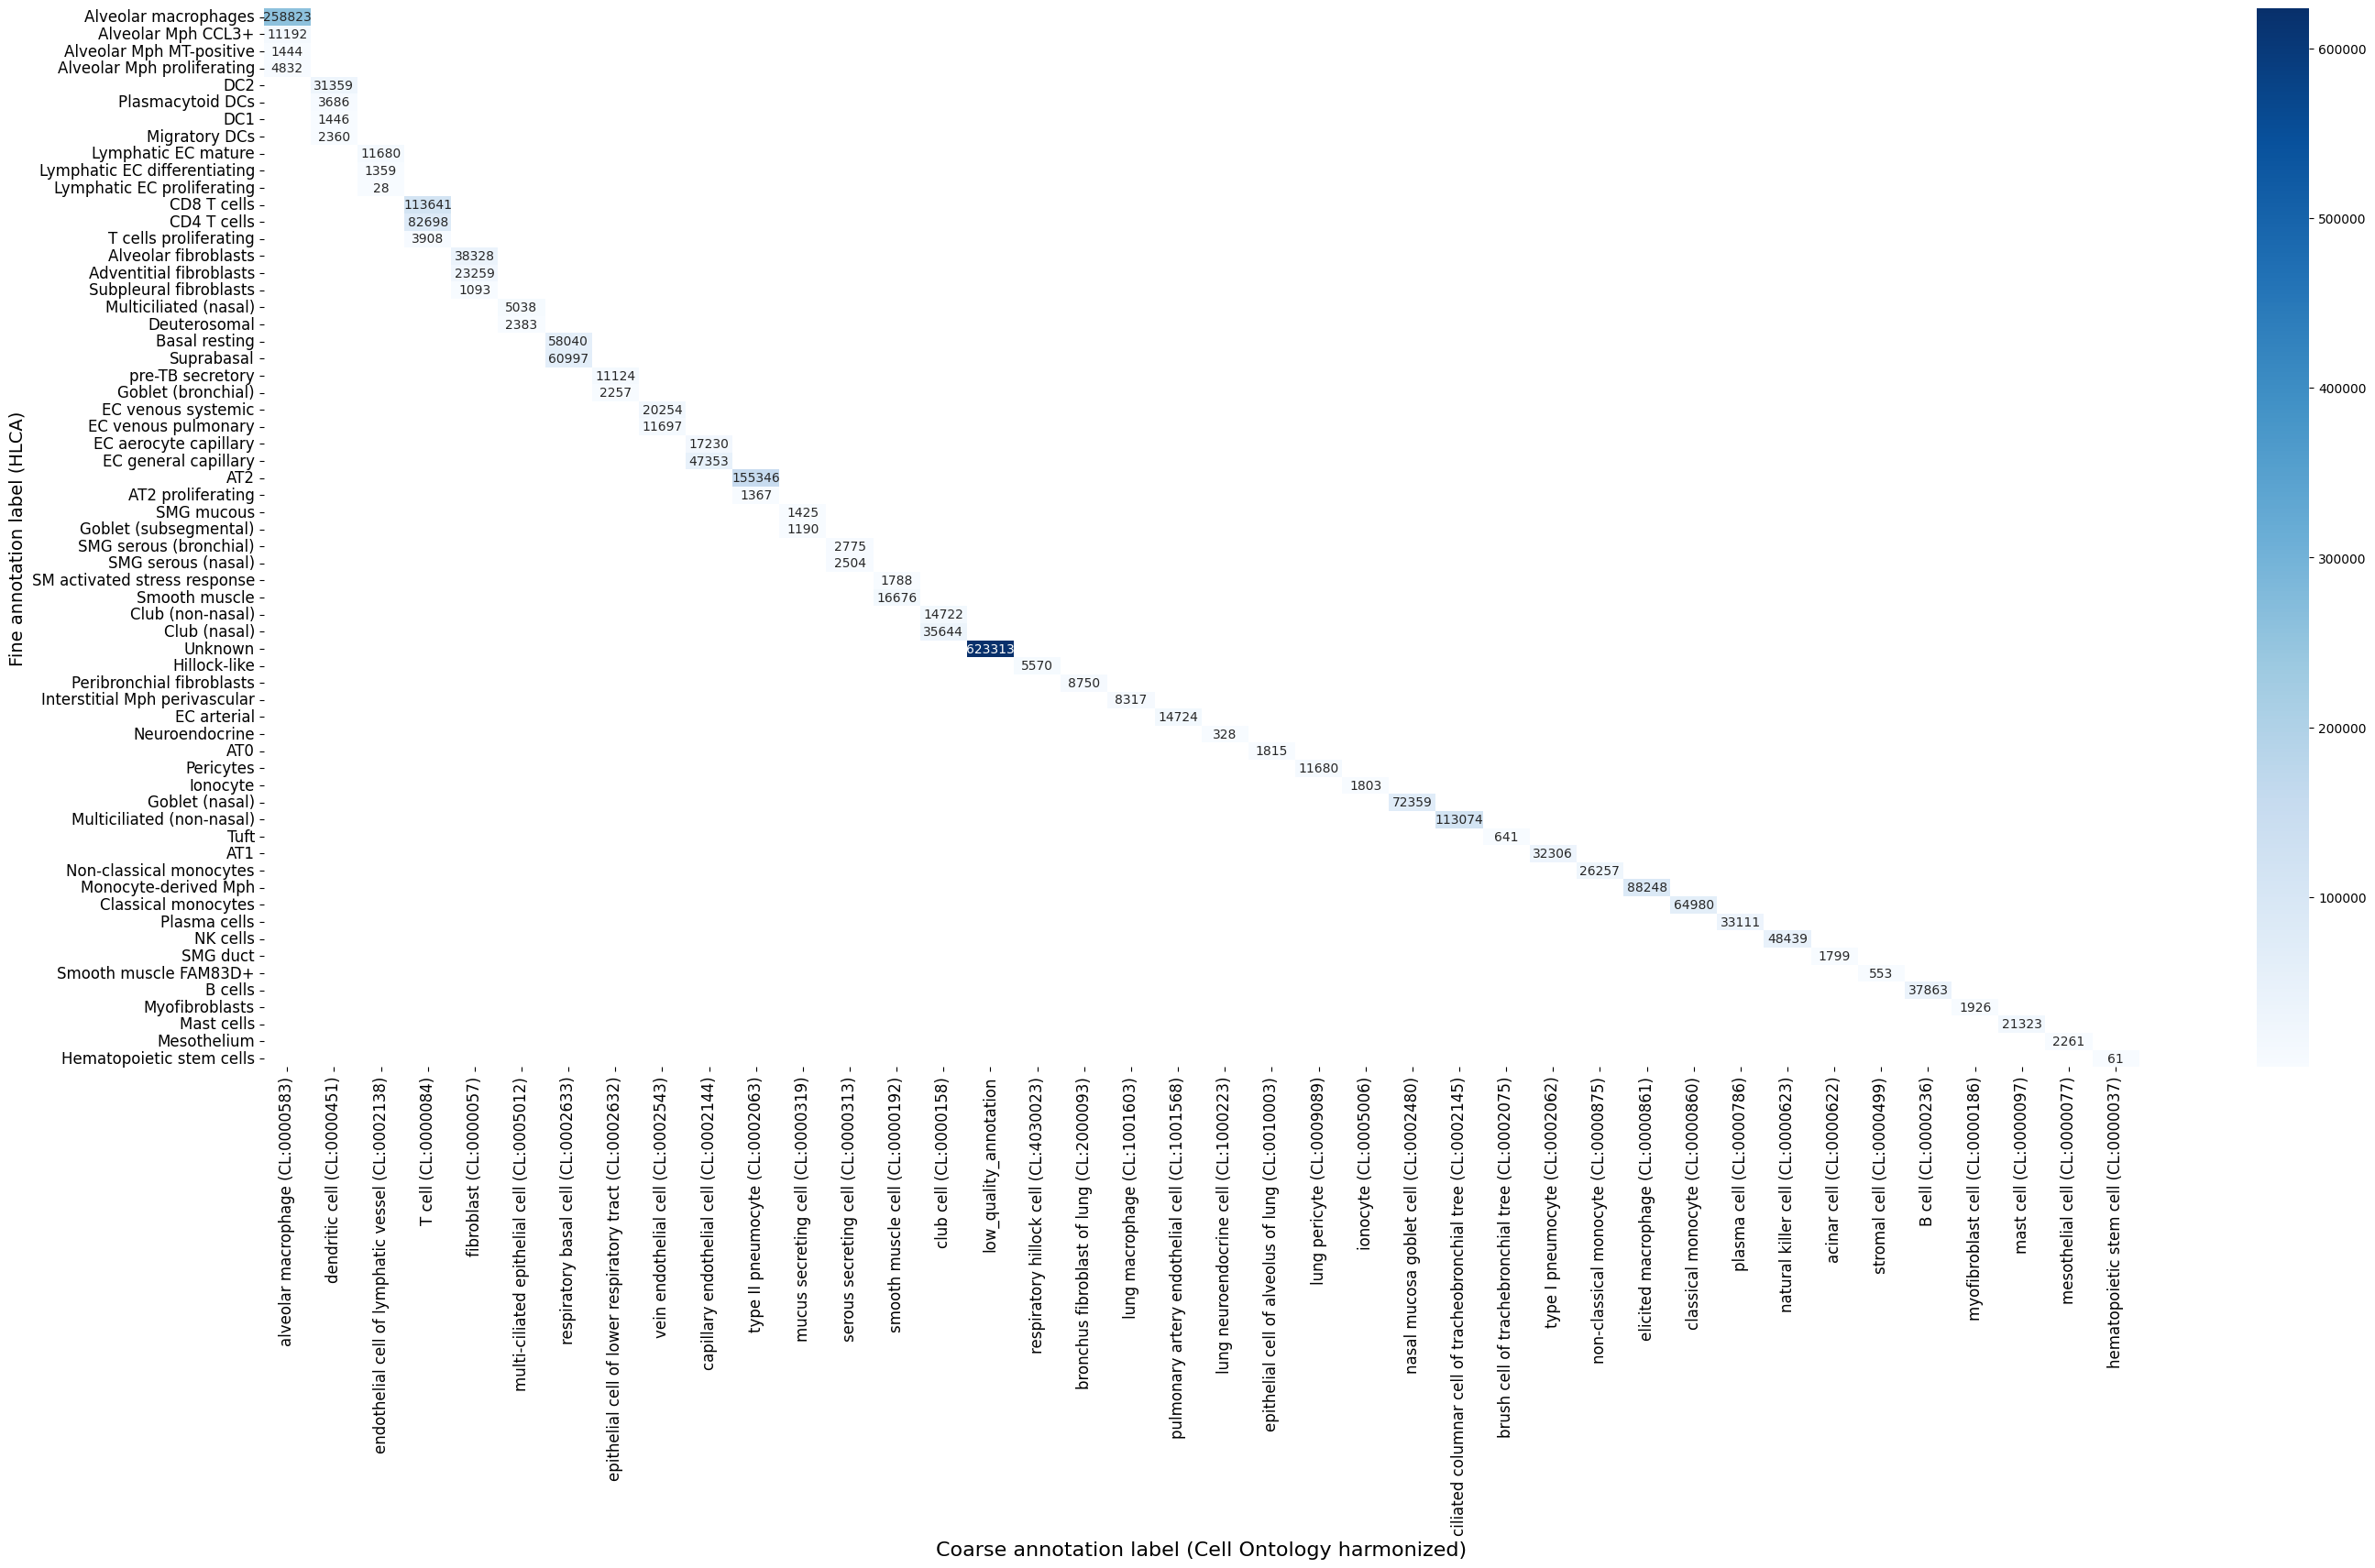

In [225]:
with plt.rc_context({"figure.figsize": (33, 15)}):
    # sns.scatterplot(data=df, x='new_name', y='original_name');
    sns.heatmap(confmat_nonzero, annot=True, cmap="Blues", fmt="g")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Coarse annotation label (Cell Ontology harmonized)", fontsize=16)  # Increase the font size of the x-axis label
    plt.ylabel("Fine annotation label (HLCA)", fontsize=14)  # Increase the font size of the y-axis label

    plt.xticks(rotation=90)

    plt.savefig(f'{figdir}/HLCA_fine_vs_coarse_celltype.pdf', bbox_inches='tight')
    plt.savefig(f'{figdir}/HLCA_fine_vs_coarse_celltype.png', bbox_inches='tight')
    plt.show()

In [226]:
hlca_adata_full.obs[fine_anno_obs].nunique()

62

In [227]:
hlca_adata_full.obs[coarse_anno_obs].nunique()

51

## Run DE analysis

#### Fine annotation

In [ ]:
data_dir = '../data/'
n_hvgs = 5000

for disease_ontology_id in select_diseases_ids:
    # Load pseudobulk data
    pbulk_adata = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
    pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    pbulk_adata.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    sc.pp.filter_genes(pbulk_adata, min_cells = 3) # exclude genes expressed in < 3 pseudobulk samples
    pbulk_adata.var['feature_id'] = pbulk_adata.var_names.values

    # Run DE analysis
    ct_res = DE_utils.celltype_marker_targets(pbulk_adata, n_hvgs = n_hvgs)
    ct_res.to_csv(f'{data_dir}/HLCA_annotation_DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')

/tmp/ipykernel_6485/838054445.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
/tmp/ipykernel_6485/838054445.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pbulk_adata.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:5

In [ ]:
data_dir = '../data/'
n_hvgs = 5000

for disease_ontology_id in select_diseases_ids:
    # Load pseudobulk data
    pbulk_adata = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
    pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    pbulk_adata.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    sc.pp.filter_genes(pbulk_adata, min_cells = 3) # exclude genes expressed in < 3 pseudobulk samples
    pbulk_adata.var['feature_id'] = pbulk_adata.var_names.values

    # Run DE analysis
    disease_res, bulk_res = DE_utils.disease_marker_targets(pbulk_adata, n_hvgs = n_hvgs)
    disease_res.to_csv(f'{data_dir}/HLCA_annotation_DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res.to_csv(f'{data_dir}/HLCA_annotation_DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

#### Coarse annotation
Re-process to use the same donors as HLCA data

In [ ]:
data_dir = '../data/'
n_hvgs = 5000

for disease_ontology_id in select_diseases_ids:
    # Load pseudobulk data
    pbulk_adata = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
    pbulk_fine_adata = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
    pbulk_adata = pbulk_adata[pbulk_adata.obs['donor_id'].isin(pbulk_fine_adata.obs['donor_id'])].copy()
    pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    pbulk_adata.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    sc.pp.filter_genes(pbulk_adata, min_cells = 3) # exclude genes expressed in < 3 pseudobulk samples
    pbulk_adata.var['feature_id'] = pbulk_adata.var_names.values

    # Run DE analysis
    ct_res = DE_utils.celltype_marker_targets(pbulk_adata, n_hvgs = n_hvgs)
    ct_res.to_csv(f'{data_dir}/HLCA_coarseannotation_DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')

/tmp/ipykernel_1021/4215751086.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
/tmp/ipykernel_1021/4215751086.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pbulk_adata.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.p

In [ ]:
data_dir = '../data/'
n_hvgs = 5000

for disease_ontology_id in select_diseases_ids:
    # Load pseudobulk data
    pbulk_adata = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
    pbulk_fine_adata = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
    pbulk_adata = pbulk_adata[pbulk_adata.obs['donor_id'].isin(pbulk_fine_adata.obs['donor_id'])].copy()
    pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    pbulk_adata.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    sc.pp.filter_genes(pbulk_adata, min_cells = 3) # exclude genes expressed in < 3 pseudobulk samples
    pbulk_adata.var['feature_id'] = pbulk_adata.var_names.values

    # Run DE analysis
    disease_res, bulk_res = DE_utils.disease_marker_targets(pbulk_adata, n_hvgs = n_hvgs)
    disease_res.to_csv(f'{data_dir}/HLCA_coarseannotation_DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res.to_csv(f'{data_dir}/HLCA_coarseannotation_DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

In [81]:
# select_diseases_ids = ['MONDO:0002771', 'MONDO:0005249', 'MONDO:0009061', 'MONDO:0005002']

## Compare prioritized targets

In [69]:
def _parse_DE(
    disease_ontology_id, 
    OT_targets_df,
    annotation_type = 'fine',
    signif_thresh = 0.1,
    DE2evidence_celltype_params = {"lfc_thresh":1.0, 'ct_fraction_thresh':1.0},
    DE2evidence_disease_params = {"lfc_thresh":1.0, 'lfc_group':'all'},
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    '''Parse DE outputs for each disease and merge with OT clinical status and genetic evidence.
    
    Params
    ------
    disease_ontology_id
        Disease MONDO ID
    OT_targets_df
        Dataframe of OpenTargets target-disease pairs
    signif_thresh
        Threshold for DE adjusted p-value
    DE2evidence_celltype_params
        parameters passed to `DE2evidence_celltype_params`
    DE2evidence_disease_params
        parameters passed to `DE2evidence_disease_params`
    data_dir 
        path to directory storing DE results
        
    Returns
    -------
    targets_disease_df
        DataFrame of target-disease pairs with clinical status and omics evidence.
    '''
    if annotation_type == 'fine':
        print('fine')
        ct_res = pd.read_csv(f'{data_dir}/HLCA_annotation_DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
        disease_res = pd.read_csv(f'{data_dir}/HLCA_annotation_DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
        bulk_res = pd.read_csv(f'{data_dir}/HLCA_annotation_DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    else:
        print('coarse')
        ct_res = pd.read_csv(f'{data_dir}/HLCA_coarseannotation_DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
        disease_res = pd.read_csv(f'{data_dir}/HLCA_coarseannotation_DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
        bulk_res = pd.read_csv(f'{data_dir}/HLCA_coarseannotation_DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')
        
    evidence_dict = sc_evidence_utils.DE2evidence_celltype(
        ct_res, signif_thresh=signif_thresh, **DE2evidence_celltype_params)
    disease_evidence = sc_evidence_utils.DE2evidence_disease(
        disease_res, bulk_res,  signif_thresh=signif_thresh, **DE2evidence_disease_params)
    disease_evidence['disease_bulk_evidence'] = np.intersect1d(disease_evidence['bulk_disease_evidence'], disease_evidence['disease_evidence'])        
    disease_evidence_new = {k: v for k, v in disease_evidence.items()}
    evidence_dict.update(disease_evidence_new)

    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)

    # Merge with Open Targets clinical status and genetic evidence
    OT_targets_disease_df = OT_targets_df[
        (OT_targets_df['disease_ontology_id'] == disease_ontology_id) & \
        ((OT_targets_df['known_drug'] > 0) | (OT_targets_df['has_genetic_support'] > 0)) 
    ].copy()

    targets_disease_df = pd.merge(OT_targets_disease_df, targets_disease_df, how='outer').fillna(0)
    return(targets_disease_df)

In [3]:
from sc_target_evidence_utils import association_utils, sc_evidence_utils

In [19]:
## Read OT evidence table
OT_targets_df =  pd.read_csv(data_dir + 'TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.clean.csv', index_col=0)
OT_targets_df['has_genetic_support'] = (OT_targets_df['genetic_association'] > 0).astype(int)

In [22]:
# targets_evidence_all = pd.read_csv(data_dir + 'disease_target_evidence.all.csv')

In [20]:
from sc_target_evidence_utils.cellontology_utils import ontology2name, get_cellontology_graph
import scipy

In [21]:
# disease_ontology_id = 'MONDO_0002771'
graph = get_cellontology_graph('../data/')

In [36]:
ids = [
    'MONDO_0002771', 
    'MONDO_0005249', 
    'MONDO_0009061'
]

In [24]:
disease_ontology_id = 'MONDO_0002771'
pbulk_adata_fine = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
pbulk_adata_coarse = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')

## Exclude genes that are not measured in HLCA dataset
exclude_genes = np.setdiff1d(pbulk_adata_coarse.var_names, pbulk_adata_fine.var_names)

# pbulk_adata_coarse[pbulk_adata_coarse.obs['disease'] != 'normal'].obs.donor_id.nunique()
# pbulk_adata_fine[pbulk_adata_fine.obs['disease'] != 'normal'].obs.donor_id.nunique()

In [25]:
## Preprocess expression
def _process_pbulk(pbulk_adata):
    cpms = scipy.sparse.csr_matrix(pbulk_adata_coarse.X.T / pbulk_adata.obs['size_factors'].values.flatten()) * 1000000
    pbulk_adata.layers['logcounts'] = np.log1p(cpms).T
    pbulk_adata.var['mean_logcounts'] = np.array(pbulk_adata.layers['logcounts'].mean(0)).flatten()

    pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(":", '_')
    pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['plot_ct_id'].astype('category')
    ct_levels = [f'{ontology2name(x, graph)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].cat.categories.str.replace("_", ":").tolist()]
    pbulk_adata.obs['high_level_cell_type'] = [f'{ontology2name(x, graph)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].str.replace("_", ":").tolist()]
    pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].astype('category').cat.reorder_categories(ct_levels)
    return(pbulk_adata)

pbulk_adata_coarse = _process_pbulk(pbulk_adata_coarse)


In [155]:
targets_res_fine_all = pd.DataFrame()
for disease_ontology_id in ids:
    targets_res_fine = _parse_DE(
                disease_ontology_id, 
                OT_targets_df,
                signif_thresh = 0.01,
                annotation_type='fine',
                DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
                DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'}
            )
    targets_res_fine_all = pd.concat([targets_res_fine_all, targets_res_fine])
    
targets_res_coarse_all = pd.DataFrame()
for disease_ontology_id in ids:
    targets_res_coarse = _parse_DE(
                disease_ontology_id, 
                OT_targets_df,
                signif_thresh = 0.01,
                annotation_type='coarse',
                DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
                DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'}
            )
    targets_res_coarse_all = pd.concat([targets_res_coarse_all, targets_res_coarse])

fine
fine
fine
coarse
coarse
coarse


In [156]:
targets_res_fine_all = targets_res_fine_all[~targets_res_fine_all.gene_id.isin(exclude_genes)]
targets_res_coarse_all = targets_res_coarse_all[~targets_res_coarse_all.gene_id.isin(exclude_genes)]

In [109]:
# df_dis = get_evidence_celltypes(DE_res_coarse, targets_res_coarse, evidence='disease', clinical_status_cols=[], signif_alpha=0.01)
# plt.hist(df_dis.sum(1), bins=df_dis.shape[1]+1);

In [157]:
import json
## Get list of all possible genes you might need 
json_file = data_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

In [158]:
results_all_df = pd.DataFrame()

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in ['ct_marker_evidence', 'disease_evidence', 'disease_bulk_evidence']:
            or_df = association_utils.get_OR(targets_res_coarse_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['annotation'] = 'coarse'
            results_all_df = pd.concat([results_all_df, or_df], axis=0)
            or_df = association_utils.get_OR(targets_res_fine_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['annotation'] = 'fine'
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

Plot intersection of detected targets

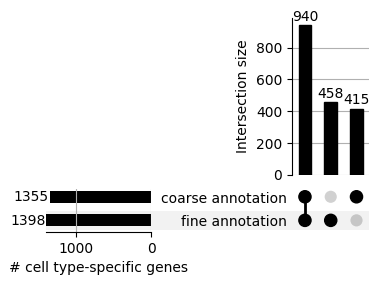

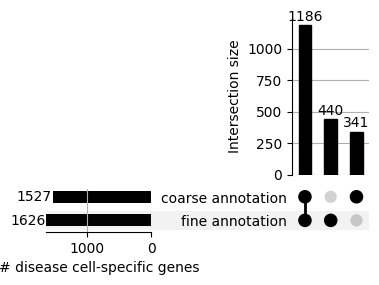

In [172]:
upset_dict = {
    'fine annotation': targets_res_fine_all[targets_res_fine_all['ct_marker_evidence'] == 1].gene_id.unique(),
    'coarse annotation':targets_res_coarse_all[targets_res_coarse_all['ct_marker_evidence'] == 1].gene_id.unique()
}

target_universe_upset = upsetplot.from_contents(upset_dict)

with plt.rc_context({'figure.figsize':[20,6]}):
    pl = upsetplot.UpSet(
        target_universe_upset, 
        orientation='horizontal', 
        show_counts = '{:d}', 
        sort_categories_by='cardinality',
        sort_by='cardinality',
        element_size=25,
        totals_plot_elements=4
    )
    plt_res = pl.plot()
    plt_res["totals"].set_xlabel("# cell type-specific genes")
    plt.savefig(figdir + 'upset_fine_vs_coarse_celltype.png')
    plt.savefig(figdir + 'upset_fine_vs_coarse_celltype.pdf')
    plt.show()
    
upset_dict = {
    'fine annotation': targets_res_fine_all[targets_res_fine_all['disease_evidence'] == 1].gene_id.unique(),
    'coarse annotation':targets_res_coarse_all[targets_res_coarse_all['disease_evidence'] == 1].gene_id.unique()
}

target_universe_upset = upsetplot.from_contents(upset_dict)

with plt.rc_context({'figure.figsize':[20,6]}):
    pl = upsetplot.UpSet(
        target_universe_upset, 
        orientation='horizontal', 
        show_counts = '{:d}', 
        sort_categories_by='cardinality',
        sort_by='cardinality',
        element_size=25,
        totals_plot_elements=4
    )
    plt_res = pl.plot()
    plt_res["totals"].set_xlabel("# disease cell-specific genes")
    plt.savefig(figdir + 'upset_fine_vs_coarse_disease.png')
    plt.savefig(figdir + 'upset_fine_vs_coarse_disease.pdf')
    plt.show()

In [173]:
%%R -i results_all_df -w 1500 -h 400
keep_ev <- c(
            'ct_marker_evidence - coarse', 'ct_marker_evidence - fine', 
            'disease_evidence - coarse', 'disease_evidence - fine',
            'disease_bulk_evidence - coarse'
        )

pl_df <- results_all_df %>%
    mutate(evidence = paste(evidence, '-', annotation)) %>%
    filter(evidence %in% keep_ev) %>%
    filter(universe == 'protein_coding_targets')
plot_OR(pl_df, y_value = 'evidence', text_position='right', 
        clinical_status_levels = c('safe', 'effective', 'approved'),
        evidence_levels = keep_ev) +
facet_grid(clinical_status~universe) +
expand_limits(x=20) 

ggsave_figdir('fine_vs_coarse_OR_plot', height=6, width=14)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


### By disease

In [165]:
def _get_disease_results(disease_ontology_id):
    DE_res_coarse = pd.read_csv(f'../data/HLCA_coarseannotation_DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')
    DE_res_fine = pd.read_csv(f'../data/HLCA_annotation_DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')

    DE_ct_res_coarse = pd.read_csv(f'../data/HLCA_coarseannotation_DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')
    DE_ct_res_fine = pd.read_csv(f'../data/HLCA_annotation_DE_celltype_{disease_ontology_id}.hvgs.csv')

    targets_res_fine = _parse_DE(
                disease_ontology_id, 
                OT_targets_df,
                signif_thresh = 0.01,
                annotation_type='fine',
                DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
                DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'}
            )

    targets_res_coarse = _parse_DE(
                disease_ontology_id, 
                OT_targets_df,
                signif_thresh = 0.01,
                annotation_type='coarse',
                DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
                DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'}
            )
    targets_res_coarse = targets_res_coarse[~targets_res_coarse.gene_id.isin(exclude_genes)]
    targets_res_fine = targets_res_fine[~targets_res_fine.gene_id.isin(exclude_genes)]

    results_all_df = pd.DataFrame()

    for u_name, u_list in universe_dict.items():
        for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
            for ev in ['ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'disease_bulk_evidence']:
                or_df = association_utils.get_OR(targets_res_coarse, ev, ot_ev, gene_universe=u_list)
                or_df['universe'] = u_name
                or_df['annotation'] = 'coarse'
                results_all_df = pd.concat([results_all_df, or_df], axis=0)
                or_df = association_utils.get_OR(targets_res_fine, ev, ot_ev, gene_universe=u_list)
                or_df['universe'] = u_name
                or_df['annotation'] = 'fine'
                results_all_df = pd.concat([results_all_df, or_df], axis=0)
    return(results_all_df)

In [166]:
results_pneumonia_df = _get_disease_results(disease_ontology_id = 'MONDO_0005249') # pneumonia
results_cf_df = _get_disease_results(disease_ontology_id = 'MONDO_0009061') # cystic fibrosis
results_pf_df = _get_disease_results(disease_ontology_id = 'MONDO_0002771') # pulm fibrosis

fine
coarse
fine
coarse
fine
coarse


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


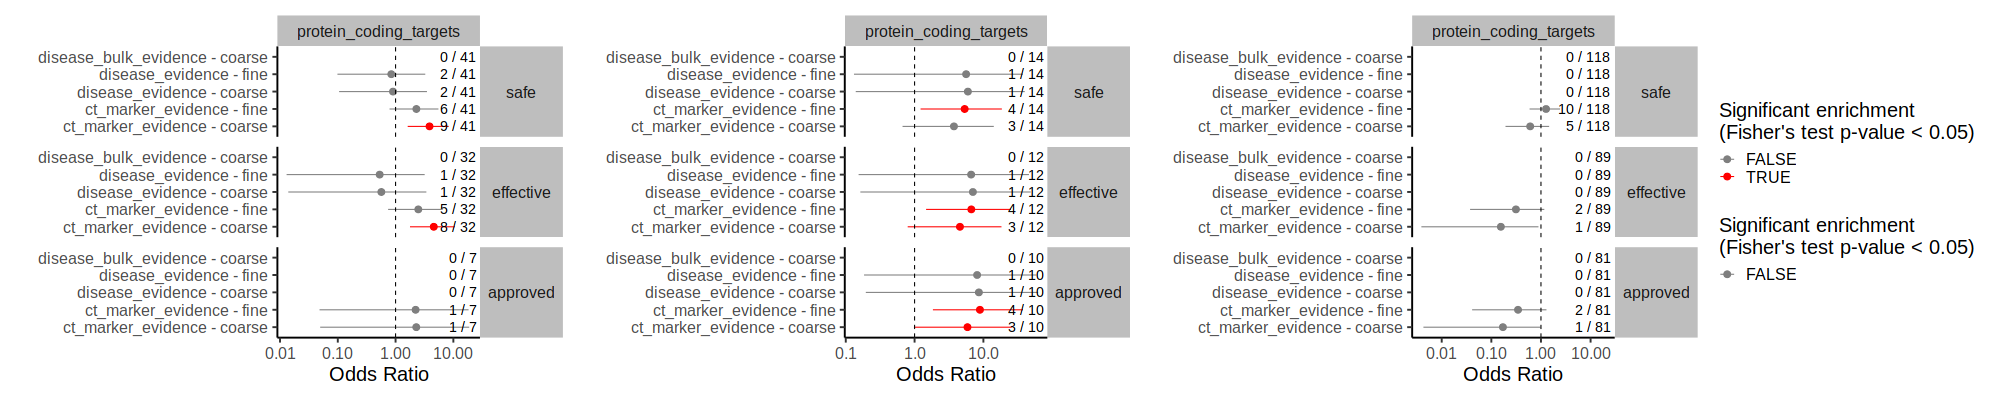

In [167]:
%%R -i results_pneumonia_df -i results_cf_df -i results_pf_df -w 2000 -h 400

keep_ev <- c(
            'ct_marker_evidence - coarse', 'ct_marker_evidence - fine', 
            'disease_evidence - coarse', 'disease_evidence - fine',
            'disease_bulk_evidence - coarse'
        )

plot_disease_results <- function(results_all_df){
    pl_df <- results_all_df %>%
        mutate(evidence = paste(evidence, '-', annotation)) %>%
        filter(universe == 'protein_coding_targets') %>%
        filter(evidence %in% keep_ev)


    plot_OR(pl_df, y_value = 'evidence', text_position='right', 
            clinical_status_levels = c('safe', 'effective', 'approved'),
            evidence_levels = keep_ev) +
    facet_grid(clinical_status~universe) +
    expand_limits(x=20) +
    ylab('')    
    }

(plot_disease_results(results_pneumonia_df) | plot_disease_results(results_pf_df) | plot_disease_results(results_cf_df)) +
plot_layout(guides='collect')


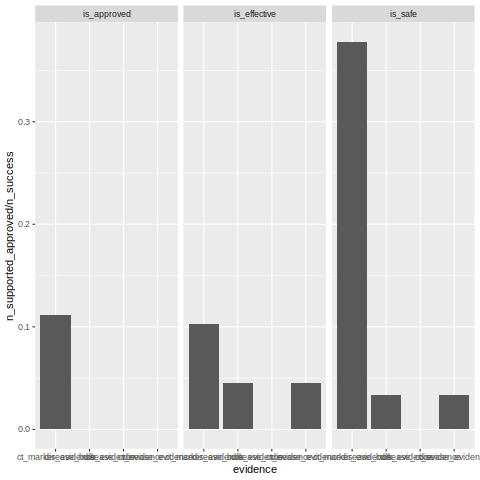

In [151]:
%%R
results_cf_df %>%
ggplot(aes(x=evidence, y=n_supported_approved/n_success)) +
geom_col() +
facet_wrap(clinical_status~.)